# Basic working examples of parameter estimation

In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using Plots
using DiffEqCallbacks
using DiffEqParamEstim
using Optim

┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.2/Thyrosim/Oo7R6.ji for Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1240


## Import data 

Jonklaas's patient description:

This consists of T4, T3 and TSH measurements of 15 hypothyroid patients (for which we know their individual height, weight and sex (mostly women)) under T3 replacement therapy. In an initial period, the right dose to give the patients was determined by adjusting the dose and measuring the patients for 8 weeks. Then the actual timecourse measurements begin for 8 hours after the last dose (either 30 or 45 ug T3, depending on the patient), every hour, except for the beginning measurement at 30 min.


+ 15 hypothyroid patients with T4, T3, TSH measurements every hour for 8 hours. 
+ Patients were given 30 or 45 $\mu g$ of T3 oral dose

In [2]:
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
tspan = (0.0, 8.0)

(0.0, 8.0)

In [3]:
# Each row is 1 patient. T4 measurements at 0, 0.5h, 1h, 2h,...,8h
patient_t4

15×10 Array{Float64,2}:
  72.0   72.0   69.0   71.0   76.0  73.0   74.0   72.0  67.0   69.0
 111.0  101.0  109.0  109.0  104.0  94.0  102.0  105.0  98.0  108.0
  11.0   16.0   14.0   15.0   15.0  19.0   19.0   13.0  15.0   14.0
  25.0   26.0   27.0   22.0   24.0  27.0   26.0   38.0  27.0   22.0
  47.0   33.0   26.0   24.0   24.0  18.0   31.0   27.0  23.0   24.0
  49.0   28.0   37.0   47.0   43.0  42.0   26.0   46.0  42.0   36.0
  17.0   16.0   15.0   30.0   26.0   6.0   24.0   17.0  32.0   23.0
  81.0   74.0   76.0   78.0   83.0  76.0   68.0   67.0  73.0   71.0
  35.0   36.0   32.0   36.0   37.0  50.0   37.0   41.0  37.0   44.0
  34.0   57.0   40.0   55.0   62.0  42.0   37.0   50.0  41.0   38.0
   9.0   11.0   15.0   13.0    9.0  10.0   13.0    5.0  10.0    6.0
  11.0   32.0    5.0   12.0    9.0  24.0   21.0   22.0  23.0   21.0
  13.0   16.0   19.0   20.0   13.0   5.0    5.0    5.0   5.0    5.0
  13.0    6.0    7.0   14.0   11.0  15.0   17.0    5.0  10.0    5.0
  31.0   39.0   36.0   3

In [4]:
# height (m), weight(kg), sex (1 = male)
patient_param

15×3 Array{Float64,2}:
 1.831   94.7  1.0
 1.618   68.3  0.0
 1.761   80.5  0.0
 1.663   78.9  0.0
 1.658   69.2  0.0
 1.675   68.3  0.0
 1.697   76.2  0.0
 1.731   65.0  0.0
 1.59    55.5  0.0
 1.64   131.2  0.0
 1.377   66.5  0.0
 1.55    79.6  0.0
 1.725  100.2  0.0
 1.658  119.0  0.0
 1.645   81.9  0.0

## Solve one patient

In [5]:
# initialize ODE problem for patient 1
i = 5
height, weight, sex = patient_param[i, :]
T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
T3dose = patient_dose[i]
ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)

# designate p55 as oral T4 dose (molecular weight = 777), p56 as oral T3 dose (molecular weight = 651)
p[55] = 0.0
p[56] = T3dose / 651.0

# gives T3 dose at hour 0
function condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
cbk = ContinuousCallback(condition, add_dose!);

# ODE problem
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
sol = solve(prob);

In [6]:
T4init, T3init, TSHinit

(47.0, 0.751, 1.22)

## Plot simulation result against real data

+ p[51] and p[52] is initialzed to be 11.0 and 5.0. Matlab's fitted values are 6.91 and 7.66. 
+ TSH appears to exhibit no fluctuations, but that's because of time scale. Increasing simulation to 24 hours will show fluctuations.

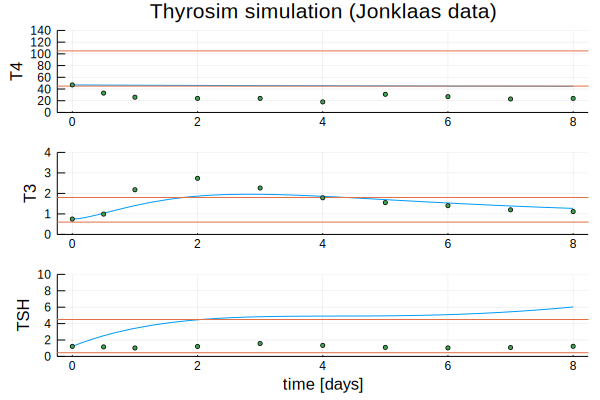

In [7]:
plot_jonklaas(sol, patient_t4[i, :], patient_t3[i, :], patient_tsh[i, :])

## Optimize Jonklaas error

Only the T3 data is being fitted, because there is too little variation in T4 data. 

Read about closures [here](http://julianlsolvers.github.io/Optim.jl/latest/#user/tipsandtricks/#_top). 

In [15]:
function fit_jonklaas()
    # initialize initial guess and fitting index
#     fitting_index = [28; 45; 30; 31; 49; 50; 51; 52; 53; 54]
#     initial_guess = [0.4978; 1.78; 101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]
    fitting_index = [28; 45]
    initial_guess = [0.4978; 1.78]

    # import data
    time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
    patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()

    return optimize(p -> jonklaas_objective(p, fitting_index, time, patient_t3, patient_param), 
                        initial_guess, NelderMead())
end

fit_jonklaas (generic function with 1 method)

In [16]:
#main objective function for T3 error only
function jonklaas_objective(p_being_optimized, fitting_index, time, patient_t3, patient_param)
    cur_error = 0.0
    tspan = (0.0, 8.0)
    cbk   = ContinuousCallback(condition, add_dose!); 

    for i in 1:size(patient_param, 1)
        
        # initialize ODE problem for patient 1
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        
        # set parameters being fitted
        p[fitting_index] .= p_being_optimized

        # solve different ODE problems for varying doses
        p[56] = patient_dose[i] / 651.0
        prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
        sol  = solve(prob, save_idxs=4)
        
        cur_error += jonklaas_error(sol, time, patient_t3[i, :], p[47])
    end
    
    return cur_error
end

jonklaas_objective (generic function with 1 method)

In [17]:
# helper function for calculating the error
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

In [18]:
result = fit_jonklaas()

 * Status: success

 * Candidate solution
    Minimizer: [9.04e-01, 1.69e+00]
    Minimum:   2.788638e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [4.98e-01, 1.78e+00]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    35
    f(x) calls:    70


In [19]:
# fitting_index = [28; 45; 30; 31; 49; 50; 51; 52; 53; 54]
# initial_guess = [0.4978; 1.78; 101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]
fitting_index = [28; 45]
initial_guess = [0.4978; 1.78]
[result.minimizer initial_guess]

2×2 Array{Float64,2}:
 0.904282  0.4978
 1.68849   1.78  

# Check optimization result by plotting

In [20]:
# check if fitting is better by plotting
p[fitting_index] = result.minimizer
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
sol = solve(prob);

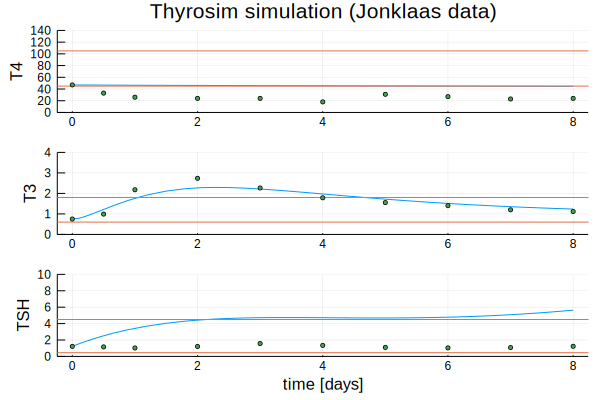

In [21]:
plot_jonklaas(sol, patient_t4[i, :], patient_t3[i, :], patient_tsh[i, :])